# Token based Classification

In the previous session, we did a document based classification. 
We chose a very particular form of representing the information which we will rarely touch in the future. 
It'll be better, going ahead to build upon last lecture by looking at another form of text classification we very frequently encounter.

![DocumentClassification.jpg](./../resources/imgs/clf-doc.jpg)

![SentenceClassification.jpg](./../resources/imgs/clf-sent.jpg)

![TokenClassification.jpg](./../resources/imgs/clf-tok.jpg)

### Changes

- We can no longer rely on one vector for a document.
- We need one 'input representation' per token.

In [1]:
from datasets import load_dataset
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
from functools import partial
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import json
import pickle
import torch
import torch.nn as nn

In [2]:
def plot_hist(data, n = 50):
    if not isinstance(data, list) or isinstance(data, np.ndarray) or isinstance(data, torch.Tensor):
        data = list(data)
    
    # lens = [len(doc) for doc in tokenized_train_text]?
    bin_ranges = [i for i in range(0, max(data), max(data)//n)]

    #create histogram with n bins
    print(f"Over {len(data)} elements, the mean is {np.mean(data):.2f} ± {np.std(data):.2f}")
    plt.figure(figsize=(14, 8))
    plt.hist(data, bins=bin_ranges, edgecolor='black')
    plt.plot()

In [3]:
dataset = load_dataset("conll2003")
dataset

Found cached dataset conll2003 (/home/priyansh/Dev/perm/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Over 21009 elements, the mean is 9.69 ± 118.22


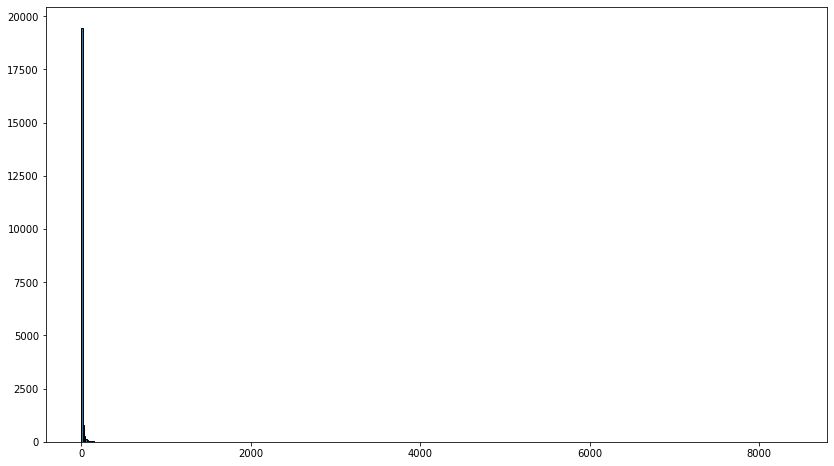

In [4]:
# Create Vocabulary
# 1. Count words
counter = ...
    
plot_hist(counter.values(), 500)


In [5]:
vocab = ... # need both pad and unk
n_words = 


4001

In [6]:
# 3. Use it to convert all tokens to word ids
train_wordid = ...

#### Label Mapping:

```json
{'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}
```

In [89]:
class_labels = {'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}

In [7]:
# 4. Collect labels for each token
train_labels = ...

In [8]:
# Do the same thing for the validation and test set
valid_wordid = ...
valid_labels = ...

test_wordid = ...
test_labels = ...

In [9]:
# 4.1 A sanity check never hurt anyone ;)
for docid, (x, y) in enumerate(zip(train_wordid, train_labels)):
    assert len(x) == len(y), f"In Doc: {docid}, X: {len(x)}, Y: {len(Y)}"
    
for docid, (x, y) in enumerate(zip(valid_wordid, valid_labels)):
    assert len(x) == len(y), f"In Doc: {docid}, X: {len(x)}, Y: {len(Y)}"
       
for docid, (x, y) in enumerate(zip(test_wordid, test_labels)):
    assert len(x) == len(y), f"In Doc: {docid}, X: {len(x)}, Y: {len(Y)}"
    
print(len(train_wordid), len(valid_wordid), len(test_wordid))

14041 3250 3453


In [10]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:            15G        5,1G        7,1G        598M        3,1G        9,3G
Swap:          979M        977M        2,1M


In [11]:
# Dump the WordID and vocab to disk
dump_dir = Path('../resources/datasets/conll2003/wordid_vocab')
dump_dir.mkdir(parents=True, exist_ok=True)
with (dump_dir/'vocab.json').open('w+') as f:
    json.dump(vocab, f)
    
with (dump_dir/'train_wordid.pkl').open('wb+') as f:
    pickle.dump(train_wordid, f)
    
with (dump_dir/'train_labels.pkl').open('wb+') as f:
    pickle.dump(train_labels, f)
    
with (dump_dir/'valid_wordid.pkl').open('wb+') as f:
    pickle.dump(valid_wordid, f)
    
with (dump_dir/'valid_labels.pkl').open('wb+') as f:
    pickle.dump(valid_labels, f)
    
with (dump_dir/'test_wordid.pkl').open('wb+') as f:
    pickle.dump(test_wordid, f)
    
with (dump_dir/'test_labels.pkl').open('wb+') as f:
    pickle.dump(test_labels, f)

In [12]:
# Load from disk (certainly for the future)
dump_dir = Path('../resources/datasets/conll2003/wordid_vocab')
assert dump_dir.exists()

with (dump_dir/'vocab.json').open('r') as f:
    vocab = json.load(f)
    
with (dump_dir / 'train_wordid.pkl').open('rb') as f:
    train_wordid = pickle.load(f)

with (dump_dir / 'train_labels.pkl').open('rb') as f:
    train_labels = pickle.load(f)

with (dump_dir / 'valid_wordid.pkl').open('rb') as f:
    valid_wordid = pickle.load(f)

with (dump_dir / 'valid_labels.pkl').open('rb') as f:
    valid_labels = pickle.load(f)

with (dump_dir / 'test_wordid.pkl').open('rb') as f:
    test_wordid = pickle.load(f)

with (dump_dir / 'test_labels.pkl').open('rb') as f:
    test_labels = pickle.load(f)

## Solution 1:
Ignore all the context, just try to map one word to its pos tag

![NoContext.jpg](./../resources/imgs/model_nocontext.png)

### Problems:

1. POS tags are context dependent. 

    - **Apple** stock just shot up
    - We be stuffing our faces with an **apple**.
    
2. If we are just mapping a token to a pos tag, why bother with documents. Just create a most frequent label dictionary?
    
    - This.. is right :P


## Solution 2:

**Ran out of time to draw illustration; will do on whiteboard ^^**

Take a context window of 1 (one token before; current token; one toke after)

In [13]:
n_words, n_labels = len(vocab), 47

In [74]:
class TriGramSampler:
    """
        Given X and Y matrices (or lists of lists),
            it returns a batch worth of stuff upon __next__
    :return:
    """

    def __init__(self, data, vocab, _batchsize: int = 64):

        self.nwords = len(vocab)
        self.x, self.y = self.preproc(inputs=data['x'], labels=data['y'])
        self.n = len(self.x)
        self.bs = _batchsize  # Batch Size
        
    def preproc(self, inputs, labels):
        X, Y = [], []
        for doc, lbls in tqdm(zip(inputs, labels)):
            doc = [-1] + doc + [-1]
            for i in range(1, len(doc)-1):
                X.append([doc[i-1], self.nwords+doc[i], self.nwords*2+doc[i+1]])
                Y.append([lbls[i-1]])
                
        return np.asarray(X, dtype=np.int), np.asarray(Y, dtype=np.int)
        

    def __len__(self):
        return self.n // self.bs - (1 if self.n % self.bs else 0)

    def __iter__(self):
        self.i, self.iter = 0, 0
        return self

    def __next__(self):
        """
        @TODO: edge case: Return leftovers.
        :return:
        """
        if self.i + self.bs >= self.n:
            raise StopIteration

        _x, _y = self.x[self.i:self.i + self.bs], self.y[self.i:self.i + self.bs]
        self.i += self.bs
        
        # Time to one-hot them
        _X = np.zeros((_x.shape[0], self.nwords*3))
        for i, __x in enumerate(_x):
            _X[i, __x] = 1
        
        return _X, _y.squeeze(1)

In [75]:
train_sampler = TriGramSampler({'x': train_wordid, 'y': train_labels}, vocab)


0it [00:00, ?it/s]

In [35]:
class PosTagger(nn.Module):
    ...

In [39]:
# init model lossfn and opt

In [41]:
# Define some metrics
def acc(y_pred, y_true):
    return torch.mean((y_pred.argmax(dim=1) == y_true)*1.0)

In [80]:
try:
    from mytorch.loops import generic_loop
except ImportError:
    ! pip install my-torch
    from mytorch.loops import generic_loop


In [81]:
traces = generic_loop(
    epochs = epochs,
    data = {"train": {"x": train_wordid, "y": train_labels}, "valid": {"x": valid_wordid, "y": valid_labels}},
    data_fn = partial(TriGramSampler, vocab=vocab),
    loss_fn = lfn,
    train_fn=m,
    predict_fn=m,
    model=m,
    device='cpu',
    opt = opt,
    eval_fn=acc
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]/home/priyansh/Dev/perm/conda/envs/main/lib/python3.8/site-packages/mytorch/loops.py:239: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  param.data = param.data.add(-weight_decay * group['lr'], param.data)
3181it [02:00, 26.35it/s]                          
802it [00:03, 223.29it/s]                         

Epoch: 000 | Loss: 0.49259 | Tr_c: 0.85216 | Vl_c: 0.87668 | Time: 2.028 min


0it [00:00, ?it/s]

0it [00:00, ?it/s]

3181it [02:10, 24.37it/s]                          
802it [00:03, 209.26it/s]                         

Epoch: 001 | Loss: 0.24718 | Tr_c: 0.91855 | Vl_c: 0.87547 | Time: 2.192 min


0it [00:00, ?it/s]

0it [00:00, ?it/s]

  5%|▌         | 172/3180 [00:07<02:05, 23.99it/s]


KeyboardInterrupt: 

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

confusion_matrix?

<AxesSubplot:>

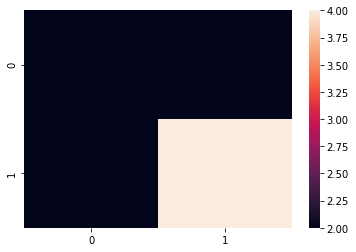

In [93]:
yt = torch.randint(0, 2, (10,))
yp = torch.randint(0, 2, (10,))
cf = confusion_matrix(yt, yp)
sn.heatmap(cf)